# QAOA for Max-Cut problem


Here, we will review the Quantum Approximate Optimization Algorithm.

The goal is to use Qiskit Runtime to solve the Max-Cut problem.

You can find the whole tutorial and a guide on how to run it in real hardware here:

https://learning.quantum.ibm.com/tutorial/quantum-approximate-optimization-algorithm

## What is the Max Cut problem?

Given a graph, we want to partition its nodes in a way that maximizes de number of edges between nodes in differing groups.

An example (where we need `rustworkx`).

    pip install rustworkx


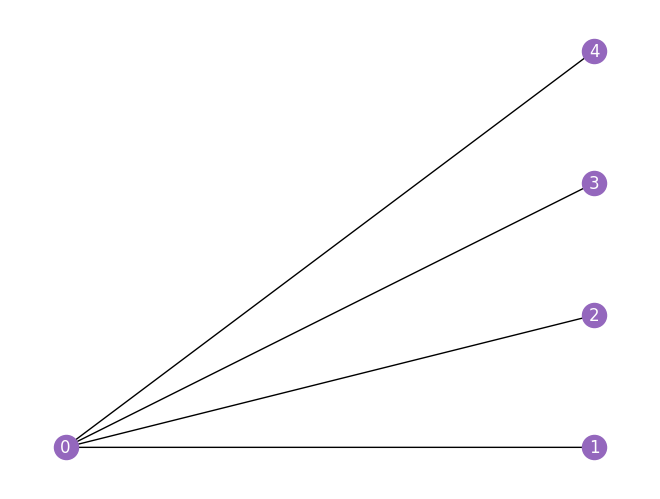

In [2]:
import rustworkx as rx
from rustworkx.visualization import mpl_draw

num_nodes = 5
edges = [(0, 1, 1), (0, 2, 1), (0, 3, 1), (0, 4, 1)]# The edge syntax is (start, end, weight)

G = rx.PyGraph()
G.add_nodes_from(range(num_nodes))
G.add_edges_from(edges)

mpl_draw(
    G, pos=rx.bipartite_layout(G, {0}), with_labels=True, node_color='tab:purple', font_color='white'
)

The first step is to build an observable, which in this case is a Hamiltonian, that will define the cost function of the problem we want to solve.

In order to map the MaxCut problem to a quantum observable, we need to sum all the combinations of applying $Z$ operators to the connected edges. 

In this case:

$IIIZZ + IIZIZ + IZIIZ + ZIIIZ \quad (= \sum_{i,j\in E} Z_iZ_j)$

Note that the we always start counting from the right.

In [ ]:
import numpy as np
from qiskit.quantum_info import SparsePauliOp

# Problem to Hamiltonian operator
hamiltonian = SparsePauliOp.from_list([("IIIZZ", 1), ("IIZIZ", 1), ("IZIIZ", 1), ("ZIIIZ", 1)])

print(hamiltonian)

## Defining the ansatz

The QAOA ansatz is predefined in Qiskit. Given the Hamiltonian of the problem $H_G$ and a number of repetitions, it will iterate the evolution of $H_G$ with evolution following the Hamiltonian

$ H = IIIIX + IIIXI + IIXII + IXIII + XIIII \quad (= \sum_i X_i)$

In this case the initial state is just all qubits to zero so we do not need to worry about it.

In [ ]:
from qiskit.circuit.library import QAOAAnsatz

# QAOA ansatz circuit
ansatz = QAOAAnsatz(hamiltonian, reps=2)

ansatz.decompose(reps=3).draw(output="mpl", style="clifford")

The previous image illustrates the ansatz in the basic gates. 

Using `reps` we can change the level of decomposition. For example, the following representation directly shows the QAOA structure.

In [ ]:
ansatz.decompose(reps=1).draw(output="mpl", style="clifford")

## Defining a cost function

The next step is to define the cost function using the estimator and the Hamiltonian. 
This is done as follows: 

In [ ]:
from qiskit.primitives import Estimator

estimator = Estimator()

# If we want to run it on the real device, use these lines instead:

#from qiskit_ibm_runtime import QiskitRuntimeService
#from qiskit_ibm_runtime import Estimator, Sampler, Session, Options

#service = QiskitRuntimeService(channel="ibm_quantum", token=<YOUR TOKEN>)
#backend = service.least_busy(operational=True, simulator=False)
#print(backend.name)

#options = Options()
#options.resilience_level = 1
#options.optimization_level = 3
 
#estimator = Estimator(backend, options=options)

def cost_func(params, ansatz, hamiltonian, estimator):
    
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (Estimator): Estimator primitive instance

    Returns:
        float: Energy estimate
    """
    
    cost = estimator.run(ansatz, hamiltonian, parameter_values=params).result().values[0]
    return cost

Now we are ready to solve the problem using the minimize scipy function:

In [ ]:
from scipy.optimize import minimize

# Randomly initialize the parameters of the ansatz
x0 = 2 * np.pi * np.random.rand(ansatz.num_parameters)

# Run the variational algorithm
res = minimize(cost_func, x0, args=(ansatz, hamiltonian, estimator),
               method="COBYLA")

print(res)

In order to check if the solution makes sense, let's plot the probabilities of the final state.

In [ ]:
from qiskit.primitives import Sampler

sampler = Sampler()

# If instead we want to run it on the device 
# we need the sampler from runtime
# sampler = Sampler(backend, options=options)

# Assign solution parameters to ansatz
qc = ansatz.assign_parameters(res.x)
qc.measure_all()

# Draw circuit with optimal parameters
#qc_ibm.draw(output="mpl", idle_wires=False, style="iqp")

In [ ]:
from qiskit.visualization import plot_distribution

# Sample ansatz at optimal parameters
samp_dist = sampler.run(qc).result().quasi_dists[0]
plot_distribution(samp_dist.binary_probabilities(), figsize=(15, 5))

We see that the final probabilities are $00001$ and $11110$, which correspond to isolating node number $0$. This is indeed the partition that would cut the maximum number of edges in the graph!

![MaxCut](image3.png)

Now you have all the tools to explore new problems.

Try to modify the Hamiltonian to define more complex graphs and check whether the QAOA algorithm gives you the right solution!